# Detecting Fake News Using Machine Learning
## Imports

First we will import everything we are going to need to train our fake news detection model.

In [1]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Data
Next we read in our data file. We check the shape and head of the data to get an idea of the structure. ***Visualization 1***

In [2]:
datafile = 'artifacts/news.csv'
df = pd.read_csv(datafile, encoding='utf-8')

df.shape
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


We will need to be able to associate the labels to the text content in our machine learning model, so we isolate and check the labels here.

In [3]:
labels = df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

Before we begin training, we should ensure we have a balanced dataset to work with. The data is almost perfectly balanced and will work well for training. ***Vizualization 2***

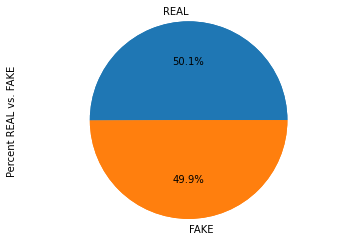

In [4]:
count = labels.value_counts()
count.rename('Percent REAL vs. FAKE', inplace=True)
count.plot.pie()
plt.pie(count, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Finally, in order to get our data ready for training,we split it into two groups of two. x train and test, and y train and test. We reserve 20% of the data for training in order to test our model's accuracy.

In [5]:
x_train,x_test,y_train,y_test = train_test_split(df['text'], labels, test_size=0.2, random_state=7)

## Training - Descriptive and Non-Descriptive Methods
### Descriptive Method
The first step in our model is to create and run the data through a TF-IDF Vectorizer. This is a useful tool that will allow us to perform a number of calculations on the data at once.

The text will be analyzed for term frequency(TF) which counts how many times a word is used in a document relative to the length of the document, as well as the inverse document frequency(IDF). IDF creates a score based on the TF with lower scores indicating higher frequency of occurence. We want to isolate the words that make the articles unique, rather than the words they have in common, in order to be able to identify what makes a news article likely to be real or fake.

First we instantiate a TF-IDF Vectorizer. The first argument in the method will exclude words common to all english sentences such as 'and' and 'the'. The second argument tells our vectorizer to ignore completely any words that occur in 70% or more of our text samples, ensuring our analysis focuses only on differences.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

Next we run our training data through our newly created Vectorizer in order to generate a set of scores. We also get the scores for the test data at the same time.

In [6]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In order to get some insight into what our model has learned about fake news, let's create a dictionary of discovered words, as well as the weights they have been assigned.

In [7]:
feature_names = tfidf_vectorizer.get_feature_names()

word_cloud_dict = {}
for col in tfidf_train.nonzero()[1]:
    if tfidf_train[0, col] != 0.0:
        word_cloud_dict[feature_names[col]] = tfidf_train[0, col]

Now we can create a wordcloud showing what words have the highest weights. ***Visualization 3***

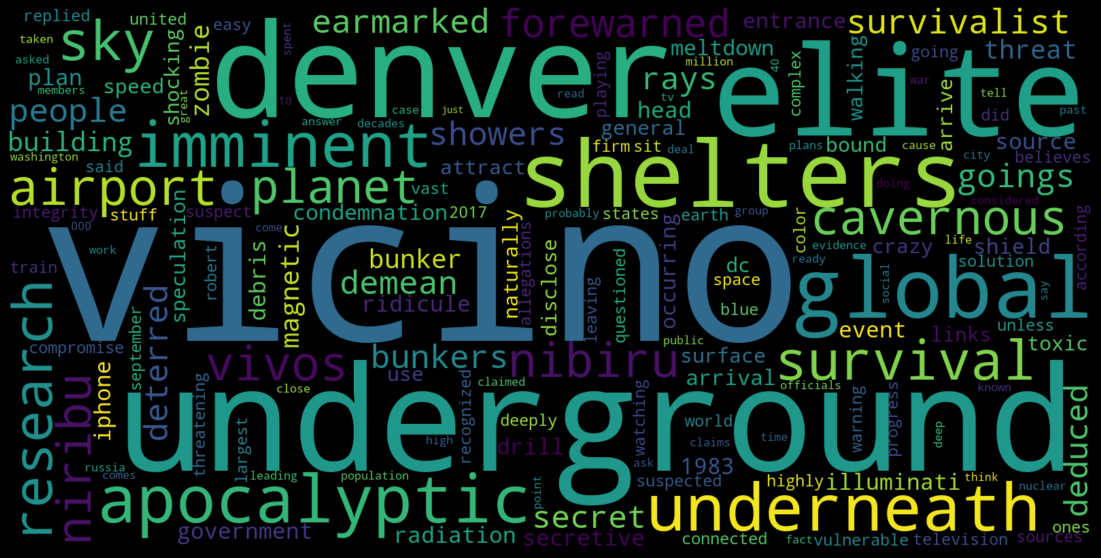

In [8]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(word_cloud_dict)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Non-Descriptive Method
To ensure the accuracy of our predictions, we will utilize a second machine learning model called a Passive Aggressive Classifier(PAC). We instantiate the object with a maximum of 50 iterations over the data.

We then fit the PAC with both our trained TF-IDF data and our untrained Y data as the target. The algorithm will iterate over the two data sets making predictions for the Y data. If the prediction is correct, no corrections will be made (passive). If the prediction is incorrect, the model will make changes to itself in an attempt to correct it (aggressive).

In [ ]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

Now that the model has been fully trained, we are ready to make a prediction. We utilize the TF-IDF test data from earlier and make a prediction whether each article should have the REAL or FALSE label. In order to confirm our prediction, we compare it to the Y test data we have been saving and see we get a prediction accuracy of 92.82%. We can now feel confident that our model has a high degree of accuracy and can use the model to test whether a news article is real or fake.

In [ ]:
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

## Accuracy
In order to get a better view of our model's accuracy, we plot the tests onto a Confusion Matrix. We can see that we have 591 true positives, 585 true negatives, 47 false positives, and 44 false negatives. ***Visualization 4***

In [ ]:
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

Having completed the training of our models, we export them here for use in our web app.

In [9]:
dump(pac, 'artifacts/pac.joblib')
dump(tfidf_train, 'artifacts/tfidf_train.joblib')
dump(tfidf_vectorizer, 'artifacts/tfidf_vectorizer.joblib')

Accuracy: 92.82%


## Accuracy
In order to get a better view of our model's accuracy, we plot the tests onto a Confusion Matrix. We can see that we have 591 true positives, 585 true negatives, 47 false positives, and 44 false negatives. ***Visualization 4***

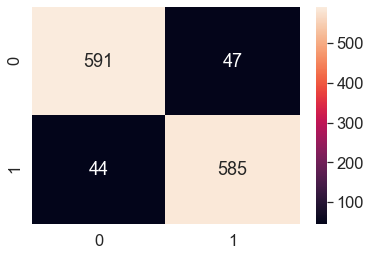

In [10]:
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

Having completed the training of our models, we export them here for use in our web app.

In [ ]:
dump(pac, 'artifacts/pac.joblib')
dump(tfidf_train, 'artifacts/tfidf_train.joblib')
dump(tfidf_vectorizer, 'artifacts/tfidf_vectorizer.joblib')